# Tweet sentiment analysis

## Posible approaches

- Translate the tweets to english (using google translate or other alternative) and then perform regular sentiment analysis in English.
- Create our own corpus (a common corpus for sentiment analysis is the imdb dataset)
- Use an existing corpus in Spanish.

## TASS Dataset

We will use an existing labeled dataset to predict the sentiment of the new tweets

I found a very, very good dataset provided by the Spanish Society for Natural Language Processing [SEPLN]. Every year they organize the TASS, a workshop focused on sentiment analysis in Spanish. They provide their [corpus](http://www.sngularmeaning.team/TASS2015/tass2015.php#corpus) for free for academic purposes.

The TASS Dataset includes many files that sum about 50000 tweets from a variety of topics (general, tv, politics, sports), and include the polarity as an ordinal variable. Polarity values include: N (negative), NEU(Neutral), P (Positive), NONE (without sentiment)

In [448]:
!head -n 30 TASS2019_country_MX_dev.xml

<?xml version="1.0" encoding="UTF-8"?>
<tweets>
	<tweet>
		<tweetid>774677024673714176</tweetid>
		<user>288849596</user>
		<content>Hoy le dÃ­ asesorÃ­a a 1 dude q qerÃ­a recuperar a su ex. Cada q habla d ella se le ilumina la cara. Voy a hacer lo imposible pa q la logre.</content>
		<date>Sat Sep 10 18:32:50 +0000 2016</date>
		<lang>es</lang>
		<sentiment>
			<polarity><value>P</value></polarity>
		</sentiment>
	</tweet>
	<tweet>
		<tweetid>773710630956130304</tweetid>
		<user>610531063</user>
		<content>Â¡RÃ¡pido a quÃ© comprar el iPhone 7 antes que saqu...! Â¿CÃ³mo, ya lo estÃ¡n presentando el 8? Bueno, ese mero a que com... Â¿Ya van en el 9?</content>
		<date>Thu Sep 08 02:32:43 +0000 2016</date>
		<lang>es</lang>
		<sentiment>
			<polarity><value>NEU</value></polarity>
		</sentiment>
	</tweet>
	<tweet>
		<tweetid>764625478317596672</tweetid>
		<user>188013030</user>
		<content>SÃ³lo y triste bajo el sol en la playa busco amor debe haber un lugar para mÃ­ Gentes vienen, gentes va

So we see that tweets come as xml files. TASS files come in different xml schemas (different TASS seminars seem to have used slightly different files), so they need to be parsed each one separately.

In [425]:
import pandas as pd
pd.set_option('max_colwidth',1000)

Once we have all the xml files parsed we concatenate them

In [426]:
types = ['_train.csv','_dev.csv']
countries = ['MX','ES','CR','PE','UY']

c = [pd.read_csv("TASS2019_country_"+ country + datatype, engine='python') for country in countries for datatype in types]
tweets_corpus = pd.concat(c)
print(tweets_corpus.columns)
tweets_corpus = tweets_corpus[["content","value"]]
tweets_corpus

Index(['tweetid', 'user', 'content', 'date', 'lang', 'value'], dtype='object')


,content,value
0,"— ¿Nivel de inglés? — Alto. — Traduzca juguete. — Toy. — Úselo en una oración. — Toy triste. — Awww, vengache pa' acá. —",NEU
1,"Si soy de área 4 y con suerte pase mate IV y mate V ¿por que me ponen al profe qlero que es mega difícil pasar con el, en mi último año?",N
2,Sabían que su after fav Teatro G. fue construido para mi y un día de estos (hoy) les voy a dar el placer de que me vean ahí metido !!,P
3,"Y hoy por primera vez me salí con el permiso de mi mujer pero no es eso el detalle, si no saber q estarán a mi lado y q llegaré a casa",P
4,"¿Para qué hacen coraje con Ambriz?, al final no lo van a correr y saldrá con su típica frase: ""La culpa es mía, no de los jugadores""",N
...,...,...
481,"@sonmifelicidad_ yo el programa!! sino lo veo en vivo se me va a complicar para verlo, acá en Uruguay la pagina de Telefe no sirve",N
482,"@sonmifelicidad_ igual este Lunes seguro vea La Doña, porque de ultima el domingo empieza, por lo menos para verla, porque ya la extraño",NEU
483,@Guille2SantosTM @urbandoficial Al contrario gracias a ustedes por compartir Saludos!,P
484,@juliapresa0 todas julinator te quiero y extraño,P


In [427]:
tweets_corpus.groupby(['value']).size()

value
N       2585
NEU      969
NONE    1263
P       1952
dtype: int64

## Label preprocessing

We will binarize the sentiment. So instead of having a 5-class classification problem we turn it into a binary one. Ideally we would perform Ordinal Classification, but scikit learn seems to be more focused on categorical/binary classification.

In [454]:
tweets_corpus = tweets_corpus[tweets_corpus.value.isin(['P', 'N'])]

tweets_corpus.loc[:,'polarity_bin'] = 0
tweets_corpus.polarity_bin.loc[tweets_corpus.value == 'P'] = 1
tweets_corpus.polarity_bin.value_counts(normalize=True)

0    0.56976
1    0.43024
Name: polarity_bin, dtype: float64

Since the problem is now a binary classification one, the score will be the Area Under the Curve (roc_auc).

At this point we would try multiple models and evaluate their performance. I have done this using Scikit Learn Laboratory (Skull). After trying multiple models (a very lenghty task), Linear Support Vector Classifier turned to be the top performant model.

Once we have the model we want to use, we do a GridSearch to find the optimal hyperparameters.

In [456]:
tweets_corpus.groupby(['value']).size()

value
N    2585
P    1952
dtype: int64

## Tokenizing & Stemming

In [433]:
#download spanish stopwords
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
spanish_stopwords = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [449]:
from string import punctuation
non_words = list(punctuation)

#we add spanish punctuation
non_words.extend(['¿', '¡'])
non_words.extend(map(str,range(10)))
print(non_words)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '¿', '¡', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [457]:
from sklearn.feature_extraction.text import CountVectorizer       
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# based on http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html
stemmer = SnowballStemmer('spanish')
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    # remove non letters
    text = ''.join([c for c in text if c not in non_words]) # ?
    # tokenize
    tokens =  word_tokenize(text)

    # stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

## Support Vector Machine

In [504]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

Using a latent semantic embedding from vectorizer and a linear support vector machine

In [529]:
vectorizer = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = stem_tokens(spanish_stopwords,stemmer))

pipeline = Pipeline([
    ('vect', vectorizer),
    ('cls', SVC(kernel='linear',probability=True)),
])


parameters = {
    'vect__max_df': (0.5, 1.9),
    'vect__min_df': (10, 20,50),
    'vect__max_features': (500, 1000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'cls__C': (0.4, 0.7, 1, 1.3),
    'cls__max_iter': (500, 1000)
}


grid_search_roc = GridSearchCV(pipeline, parameters, n_jobs=-1 , scoring='roc_auc')
grid_search_f1 = GridSearchCV(pipeline, parameters, n_jobs=-1 , scoring='f1')

In [506]:
grid_search_roc.fit(tweets_corpus.content, tweets_corpus.polarity_bin)

C:\Users\User\miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\User\miniconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-proce

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(stop_words=['de', 'la',
                                                                    'que', 'el',
                                                                    'en', 'y',
                                                                    'a', 'los',
                                                                    'del', 'se',
                                                                    'las',
                                                                    'por', 'un',
                                                                    'para',
                                                                    'con', 'no',
                                                                    'una', 'su',
                                                                    'al', 'lo',
                                                                    'como',
 

In [507]:
grid_search_f1.fit(tweets_corpus.content, tweets_corpus.polarity_bin)

C:\Users\User\miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Users\User\miniconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-proce

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(stop_words=['de', 'la',
                                                                    'que', 'el',
                                                                    'en', 'y',
                                                                    'a', 'los',
                                                                    'del', 'se',
                                                                    'las',
                                                                    'por', 'un',
                                                                    'para',
                                                                    'con', 'no',
                                                                    'una', 'su',
                                                                    'al', 'lo',
                                                                    'como',
 

In [510]:
grid_search_roc.best_params_

{'cls__C': 0.4,
 'cls__max_iter': 1000,
 'vect__max_df': 0.5,
 'vect__max_features': 1000,
 'vect__min_df': 10,
 'vect__ngram_range': (1, 2)}

In [511]:
grid_search_f1.best_params_

{'cls__C': 0.4,
 'cls__max_iter': 1000,
 'vect__max_df': 0.5,
 'vect__max_features': 1000,
 'vect__min_df': 10,
 'vect__ngram_range': (1, 2)}

Save the model

In [512]:
import joblib
joblib.dump(grid_search, 'grid_search.pkl')

['grid_search.pkl']

## Validation

In [515]:
model = SVC(C=0.4, max_iter=1000,tol=0.0001)

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    stop_words = spanish_stopwords,
    min_df = 10,
    max_df = 0.5,
    ngram_range=(1, 1),
    max_features=1000
)

corpus_data_features = vectorizer.fit_transform(tweets_corpus.content)
corpus_data_features_nd = corpus_data_features.toarray()
model.fit(corpus_data_features, tweets_corpus.polarity_bin)


SVC(C=0.4, max_iter=1000, tol=0.0001)

In [516]:
metrics = ["f1", "roc_auc", "accuracy"]
scores = [cross_val_score(
    model,
    corpus_data_features,
    y=tweets_corpus.polarity_bin,
    scoring=m,
    cv=5
    ) for m in metrics]

dict(zip(metrics,[score.mean() for score in scores]))

C:\Users\User\miniconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\User\miniconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\User\miniconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\User\miniconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\User\miniconda3\lib\site-pa

{'f1': 0.6911661614820208,
 'roc_auc': 0.8106318795930811,
 'accuracy': 0.7505007552613301}

Our model has an AUC of 0.92 That will work!.

## Prediction

Now we use the trained model to predict sentiment on the downloaded tweets on 495 unseen labeled tweets from Mexico.

In [517]:
tweets_test = pd.read_csv('TASS2019_country_MX_test.csv', engine='python') 
tweets_test = tweets_test[["content","value"]]
tweets_test

,content,value
0,Soy mas complicado que una mujer jajajajaja,N
1,"@CFE_GolfoNte @Cicmty buenos días, seguimos sin servicio!",N
2,"Se viene la goleada, ya pitale árbitro... O quiten a Ochoa para que no se lo chinguen",N
3,"Que gane el Madrid, pero que mi Ochoa no salga tan mal parado",NEU
4,@minideeharry yo pensé que ya te habías olvidado de nuestra hermandad chingona lo que es tener vida social y olvidarse de uno,P
...,...,...
491,"Si quieren que aprenda algo de eso dejen esa materia sola un semestre completo, si no como",NEU
492,Últimos momentos en medicina familiar y de guardia C,NONE
493,"@natyamezcua hay pues hay que ver que hacemos para vernos, te extraño, no quiero que te alejes",NEU
494,Me acabo de tragar un pastel en mood celina,N


In [520]:
tweets_test = tweets_test[tweets_test.value.isin(['P', 'N'])]

tweets_test.loc[:,'polarity_bin'] = 0
tweets_test.polarity_bin.loc[tweets_test.value == 'P'] = 1
print(tweets_test.value.value_counts())
tweets_test.value.value_counts(normalize=True)

N    259
P    146
Name: value, dtype: int64


N    0.639506
P    0.360494
Name: value, dtype: float64

In [521]:
pipeline = Pipeline([
    ('vect', vectorizer),
    ('cls', model),
])

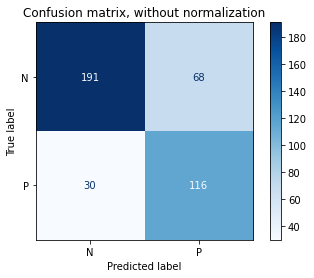

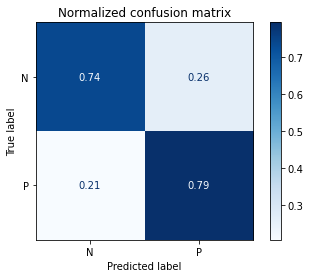

In [522]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(pipeline, tweets_test.content, tweets_test.polarity_bin,
                                 display_labels=["N","P"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    disp.confusion_matrix

plt.show()

In [523]:
(212+109)/(212+109+47+37)

0.7925925925925926

In [524]:
(191+116)/(191+116+68+30)

0.7580246913580246